[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

BASE_URL = os.getenv("BASE_URL")
API_KEY = os.getenv("API_KEY")
APP_CODE = os.getenv("APP_CODE")
OPENAI_API_KEY= os.getenv("OPENAI_API_KEY")


llm = ChatOpenAI(
    # model="misa-qwen3-30b",
    model="misa-qwen3-235b",
    base_url=BASE_URL,
    api_key=API_KEY,
    default_headers={
        "App-Code": APP_CODE
    },
    max_tokens=256,
    temperature=0.7,
    extra_body={
        "service": "test-aiservice.misa.com.vn",
        "chat_template_kwargs": {            
            "enable_thinking": False
        }
    }
)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content="That's great to hear! Whales are just one fascinating part of the ocean mammal world. There are many other marine mammals you might find interesting to learn about. Here's a breakdown of the main groups and examples from each category:\n\n---\n\n### 🐬 **Cetaceans (Whales, Dolphins, and Porpoises)**\nThese are the fully aquatic mammals, including the whales you already know.\n\n- **Dolphins**: Bottlenose dolphin, orca (also known as killer whale), spinner dolphin, beluga whale.\n- **Porpoises**: Harbor porpoise, Dall’s porpoise.\n- **Other whales**: Sperm whale, humpback whale, blue whale, narwhal, minke whale.\n- **River dolphins**: Amazon river dolphin (pink dolphin), Ganges river dolphin.\n\n---\n\n### 🦭 **Pinnipeds (Seals, Sea Lions, and Walruses)**\nThese are semi-aquatic mammals—they spend time both in water and on land (or ice).\n\n- **Seals**: Harbor seal, leopard seal, elephant seal.\n- **Sea lions**: California sea lion, Steller sea lion.\n- **Walruses**: At

We can run our chat model in a simple graph with `MessagesState`.

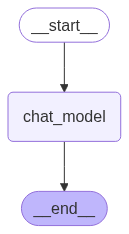

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are a fantastic starting point—there's so much to learn about them. But the world of ocean mammals is much broader and includes a wide variety of fascinating creatures. Here are some other ocean mammals you should definitely learn about:

---

### 🐬 **Dolphins and Porpoises**
- **Dolphins** are highly intelligent and social animals. Some well-known species include:
  - **Bottlenose Dolphin**
  - **Orca (Killer Whale)** – technically part of the dolphin family!
  - **Spinner Dolphin**
  - **Amazon River Dolphin** – lives in freshwater!

- **Porpoises** are similar to dolphins but generally sma

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

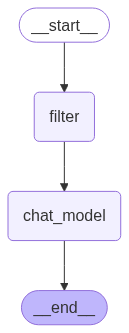

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great to hear—you're off to a good start with whales! 🐋 There are many fascinating ocean mammals beyond whales that are definitely worth learning about. Here's a list of ocean mammals you should consider studying:

---

### 🐬 1. **Dolphins**
- **Overview:** Highly intelligent, social marine mammals known for their playful behavior.
- **Species to Study:**
  - Bottlenose dolphin
  - Orca (Killer Whale) – technically a dolphin
  - Spinner dolphin
  - Beluga whale (can be included here, though more closely related to narwhals)
- **Interesting Traits:** Use echolocation, have complex communication and social s

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

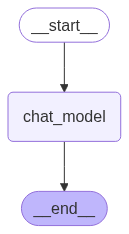

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great to hear—you're off to a good start with whales! 🐋 There are many fascinating ocean mammals beyond whales that are definitely worth learning about. Here's a list of ocean mammals you should consider studying:

---

### 🐬 1. **Dolphins**
- **Overview:** Highly intelligent, social marine mammals known for their playful behavior.
- **Species to Study:**
  - Bottlenose dolphin
  - Orca (Killer Whale) – technically 

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great to hear—you're off to a good start with whales! 🐋 There are many fascinating ocean mammals beyond whales that are definitely worth learning about. Here's a list of ocean mammals you should consider studying:

---

### 🐬 1. **Dolphins**
- **Overview:** Highly intelligent, social marine mammals known for their playful behavior.
- **Species to Study:**
  - Bottlenose dolphin
  - Orca (Killer Whale) – technically 

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

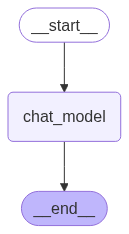

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

1. filtering message bằng `RemoveMessage` kết hợp `add_message`
2. trim message bằng `trim_messages` để trim theo token, để tiền xử lý message, không phải là channel như `add_message`